# Email Spam Detection using Machine Learning

## About Project

Spam refers to unsolicited and often irrelevant or inappropriate messages sent in bulk, typically via email or other digital communication channels. These messages are often commercial, promoting products, services, or fraudulent schemes.

A spam classifier is a machine learning model or algorithm designed to detect and filter spam messages from legitimate ones automatically. It analyzes the content and characteristics of incoming messages, such as emails or text messages, and assigns them a probability score of being spam. 

![Alt text](https://repository-images.githubusercontent.com/218616244/c4183680-fb99-11e9-8191-d7c5dfb6a11e)

# 1. Importing Libraries

In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
from collections import  Counter
import nltk
import pickle
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sankm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sankm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Loading the dataset

In [134]:
# Importing Dataset
df = pd.read_csv("data/spam.csv", encoding="latin-1")

In [135]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# 2. Data Preprocessing

In [136]:
# Dataset with required features only so dropping extra columns
df =df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [137]:
df.sample(3)

,v1,v2
4582,spam,For ur chance to win a å£250 wkly shopping spr...
3731,ham,Gud mrng dear hav a nice day
2700,ham,"Feb &lt;#&gt; is \I LOVE U\"" day. Send dis t..."


In [138]:
# Rename the Features
df.rename(columns={"v1": "output","v2": "input"}, inplace = True)

In [139]:
df.sample(1)

,output,input
1221,ham,Prakesh is there know.


## Lable Encoder

In [140]:
# Encoding Target Feature 
le = LabelEncoder()
df["output"] = le.fit_transform(df["output"])



In [141]:
df.sample(1)

,output,input
1827,0,Hey gorgeous man. My work mobile number is. Ha...


# 3. 📊 Exploratory Data Analysis 📊

In [142]:
# Shape of the Dataset
df.shape

(5572, 2)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   output  5572 non-null   int32 
 1   input   5572 non-null   object
dtypes: int32(1), object(1)
memory usage: 65.4+ KB


In [144]:
# Check Null Values
df.isnull().sum()

output    0
input     0
dtype: int64

In [145]:
# Check Duplicate Values
df.duplicated().sum()

403

In [146]:
# Drop Duplicates
df = df.drop_duplicates(keep="first")

In [147]:
df.shape

(5169, 2)

In [148]:
df.tail()

,output,input
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...
5571,0,Rofl. Its true to its name


In [149]:
# Ham & Spam Counts
df["output"].value_counts()

output
0    4516
1     653
Name: count, dtype: int64

## Pie Chart

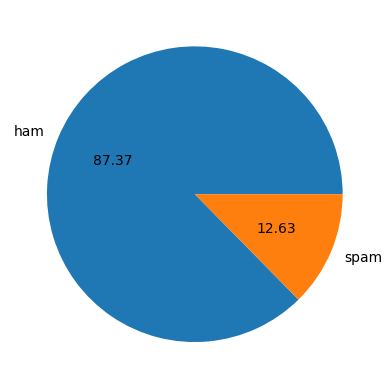

In [150]:
plt.pie(df["output"].value_counts(),autopct = "%.2f", labels=['ham','spam'])
plt.show()

**Observations:**
- Data is Imblanced
- Having Fewer Spam Messages in the Dataset

# 4. 🔧 Feature Engineering 🔧

## Feature Extraction

In [151]:
# Total No. of Characters in Data
df["characters"] = df["input"].apply(len)

In [152]:
# Total No. of Words in Data
df["word"] = df["input"].apply(lambda x:len( nltk.word_tokenize(x)))

In [153]:
# Total No. of Sentence
df["sentence"] = df["input"].apply(lambda x:len(nltk.sent_tokenize(x)))

In [154]:
df.head(1)

,output,input,characters,word,sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2


In [155]:
# Statistical Analysis of new features
df[["characters","word", "sentence"]].describe()

,characters,word,sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [156]:
# Statistical Analysis of HAM and SPAM
df[["characters","word", "sentence"]].groupby(df.output).describe().transpose()

# 0 == HAM ; 1 == SPAM

output                      0           1
characters count  4516.000000  653.000000
           mean     70.459256  137.891271
           std      56.358207   30.137753
           min       2.000000   13.000000
           25%      34.000000  132.000000
           50%      52.000000  149.000000
           75%      90.000000  157.000000
           max     910.000000  224.000000
word       count  4516.000000  653.000000
           mean     17.123782   27.667688
           std      13.493970    7.008418
           min       1.000000    2.000000
           25%       8.000000   25.000000
           50%      13.000000   29.000000
           75%      22.000000   32.000000
           max     220.000000   46.000000
sentence   count  4516.000000  653.000000
           mean      1.820195    2.970904
           std       1.383657    1.488425
           min       1.000000    1.000000
           25%       1.000000    2.000000
           50%       1.000000    3.000000
           75%       2.000000    4.000000
           max      38.000000    9.000000

## Histogram Plot 

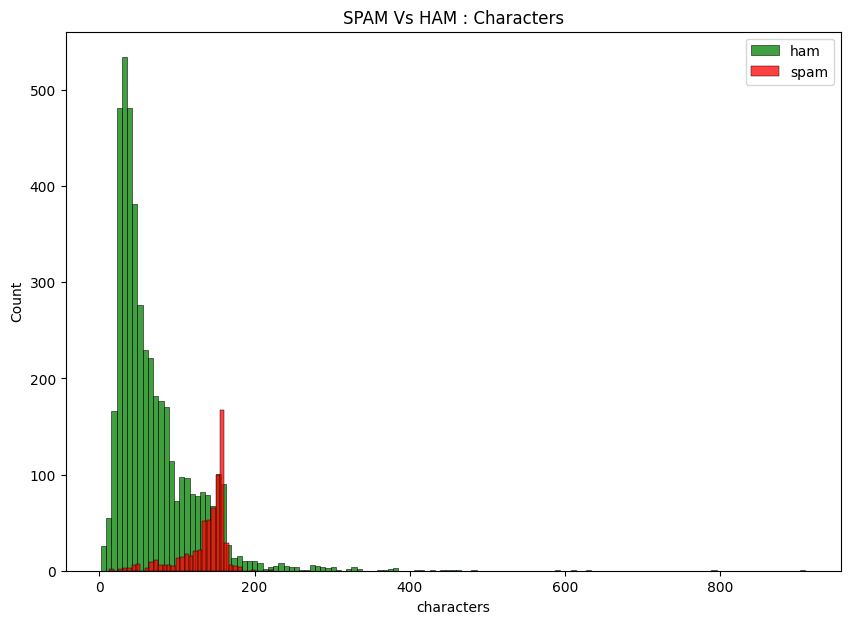

In [157]:
plt.figure(figsize=(10,7))
sns.histplot(df[df["output"]==0]["characters"],label= "ham",color="green")
sns.histplot(df[df["output"]==1]["characters"],label= "spam",color = "red")
plt.title("SPAM Vs HAM : Characters")
plt.legend()
plt.show()

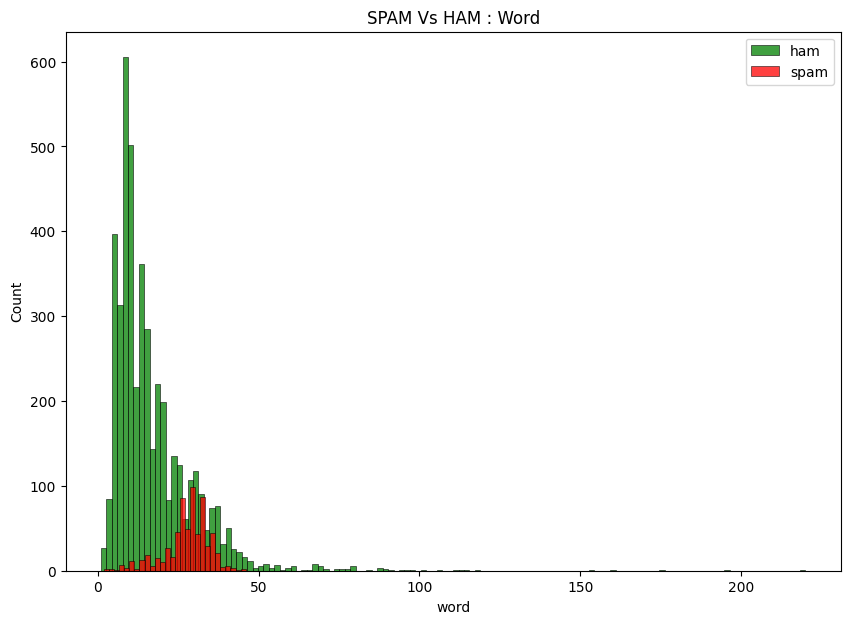

In [158]:
plt.figure(figsize=(10,7))
sns.histplot(df[df["output"]==0]["word"],label= "ham",color="green")
sns.histplot(df[df["output"]==1]["word"],label= "spam",color = "red")
plt.title("SPAM Vs HAM : Word")
plt.legend()
plt.show()

**Observations:**
- Ham Characters and Words are more than Spam

## Pair Plot

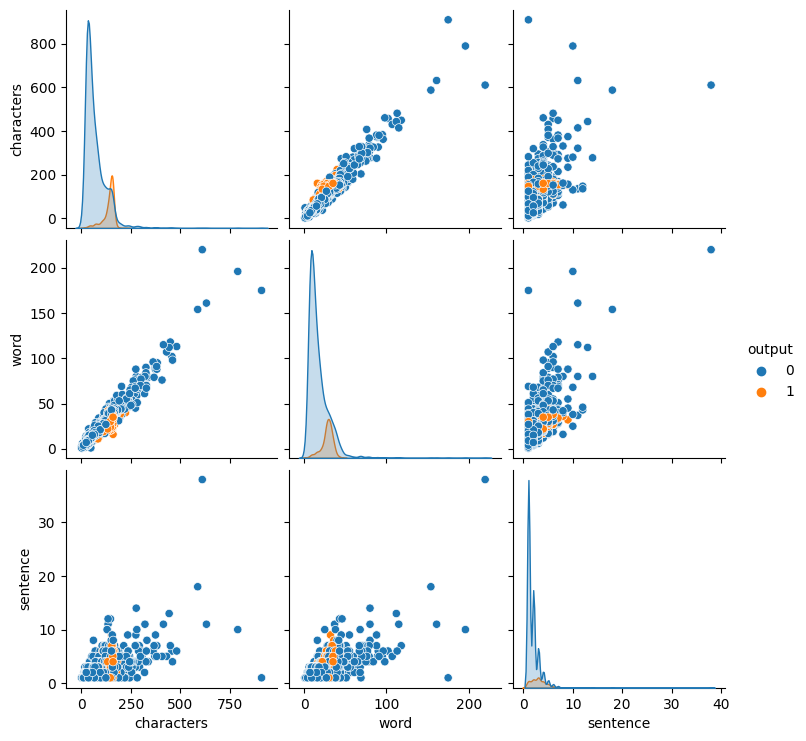

In [159]:
sns.pairplot(df,hue="output")

**Observations:**
- Outliers are present

## 🌡️ Heatmap 🌡️

In [160]:
# Correlations between features
corr = df[['output', 'characters', 'word', 'sentence']].corr()
corr

,output,characters,word,sentence
output,1.000000,0.384717,0.262912,0.263939
characters,0.384717,1.000000,0.965760,0.624139
word,0.262912,0.965760,1.000000,0.679971
sentence,0.263939,0.624139,0.679971,1.000000


<Axes: >

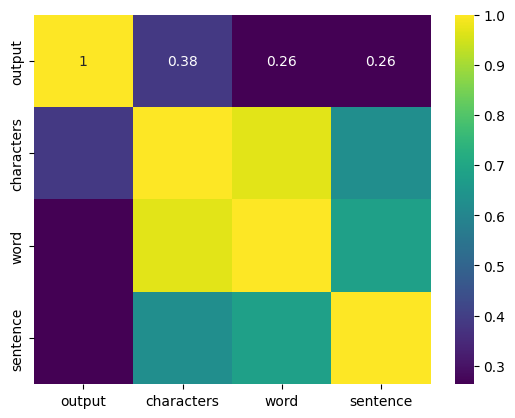

In [161]:
sns.heatmap(corr,annot=True,cmap="viridis")

**Observations:**
- "Characters" and "Word" have a moderately strong positive correlation of 0.965307

In [162]:
# Intilizing Porter Stemmer Class
ps = PorterStemmer()

In [163]:
# This Function helps to get Ready!!!

def data(text):
    text = text.lower()               #  Converts Text in Lower Case
    text = nltk.word_tokenize(text)   #  Breaks Text in Words 
    
    y = []
    for i in text:
        if i.isalnum():               #  Removing Special Characters
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:                    #  Removing Stopwords and Punctuation
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:                    #  Porter Stemmer removing unwanted words
        y.append(ps.stem(i))
        
    return " ".join(y)

In [164]:
# Checking data function 
data("shree ram 🚩 and shree mahakaleshawar 🔱 are everything for me")

'shree ram shree mahakaleshawar everyth'

In [165]:
df.sample(2)

,output,input,characters,word,sentence
2540,0,"They said if its gonna snow, it will start aro...",112,26,2
2335,0,Which is weird because I know I had it at one ...,51,12,1


In [166]:
# Transforming dataset using the "data" function in new column "new_data"
df["new_data"] = df["input"].apply(data)

In [167]:
df.sample(5)

,output,input,characters,word,sentence,new_data
68,1,"Did you hear about the new \Divorce Barbie\""? ...",80,20,2,hear new come ken stuff
4747,0,The beauty of life is in next second.. which h...,133,30,3,beauti life next second hide thousand secret w...
1062,0,Ok. Not sure what time tho as not sure if can ...,122,30,4,sure time tho sure get librari class tri see p...
414,1,100 dating service cal;l 09064012103 box334sk38ch,49,8,1,100 date servic cal l 09064012103 box334sk38ch
4290,0,Call me when u're done...,25,7,1,call u done


## Word Cloud

In [168]:
wc = WordCloud(
    background_color=None,
    width=800,
    height=400
)

In [169]:
# Wordcloud for SPAM
spam_wc = wc.generate(df[df["output"] ==1]["new_data"].str.cat(sep=" "))

# Wordcloud for HAM
ham_wc = wc.generate(df[df["output"] ==0]["new_data"].str.cat(sep=" "))

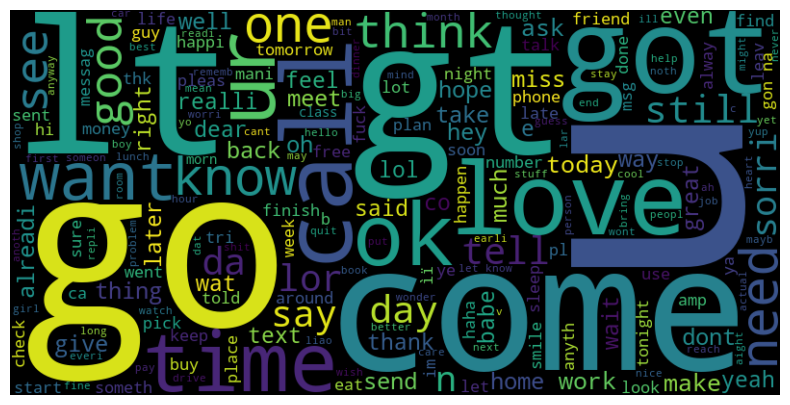

In [170]:
# SPAM 
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

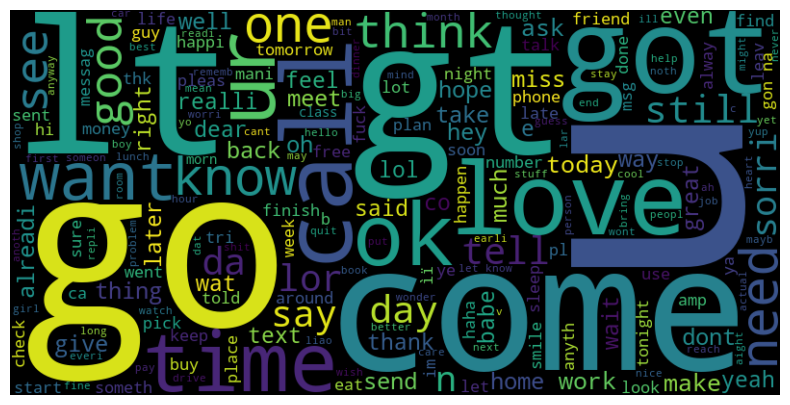

In [171]:
# HAM
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [172]:
# Spliting SPAM Sentences in Words
spam_corpus = []
for msg in df[df["output"]==1]["new_data"].tolist():
    for word in msg.split():
        spam_corpus.append(word)

## Bar Plot

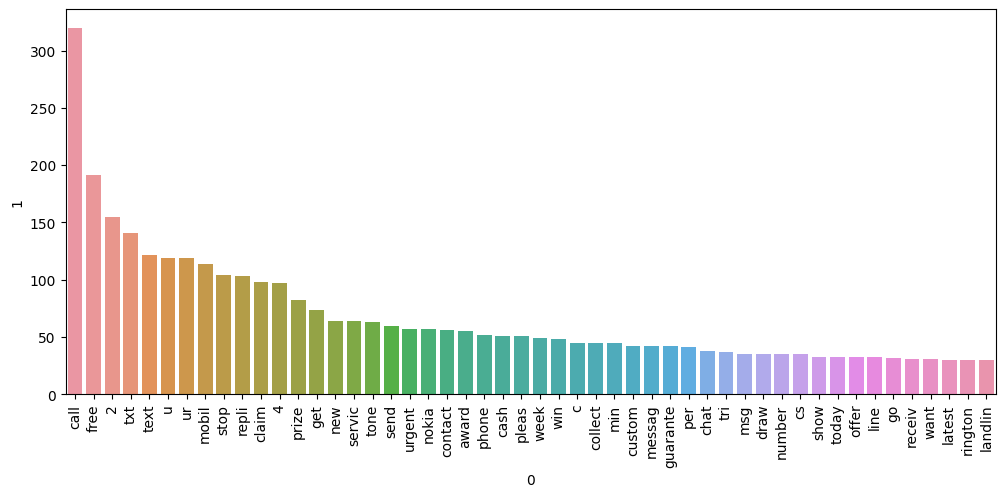

In [173]:
# Top 50 SPAM Words
a=pd.DataFrame(Counter(spam_corpus).most_common(50))[0]
b=pd.DataFrame(Counter(spam_corpus).most_common(50))[1]
plt.figure(figsize=(12,5))
sns.barplot(x= a,y=b)
plt.xticks(rotation=90)

plt.show()

In [174]:
# Spliting HAM Sentences in Words
ham_corpus = []
for msg in df[df['output'] == 0]['new_data'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

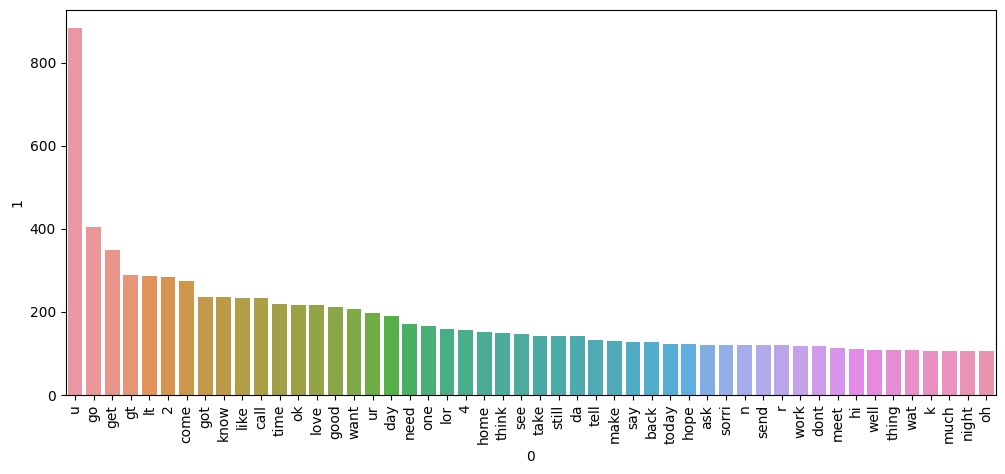

In [175]:
# Top 50 HAM Words
a=pd.DataFrame(Counter(ham_corpus).most_common(50))[0]
b=pd.DataFrame(Counter(ham_corpus).most_common(50))[1]
plt.figure(figsize=(12,5))
sns.barplot(x= a,y=b)
plt.xticks(rotation=90)

plt.show()

## Vectorization

In [176]:
# Initilizing TFIDF Vectorizer
tfidv = TfidfVectorizer(max_features=3000)

In [177]:
# Independent Feature
X = tfidv.fit_transform(df["new_data"]).toarray()

In [178]:
# Dependent Feature
y = df["output"].values

In [179]:
# Performing Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

# Models Training

In [180]:
# Models that are going to be trained
models={
    "Gaussian NB" : GaussianNB(),
    "Logistic Regression" : LogisticRegression(),
    "SVC" : SVC(),
    "Decision Tree" : DecisionTreeClassifier(),
    "KNN" : KNeighborsClassifier(),
    "Random Forest" : RandomForestClassifier()
}

In [181]:
# Creating a function train each model and calculate/return accuracy and precision
def train_clf (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    
    return acc, pre

In [182]:
# A FOR loop Calls "traim_clf" for each model and stores accuracy and precision
acc_s=[]
pre_s=[]

for name, model in models.items():
    accuracy, precision = train_clf(model, X_train, y_train, X_test, y_test)
    
    acc_s.append(accuracy)
    pre_s.append(precision)

In [183]:
# As Precision matter over Accuracy in this Data, Sorting in DESC order of Precision. All Scores of Models

scores_df = pd.DataFrame({"Algorithm": models.keys(), 
                          "Accuracy": acc_s, 
                         "Precision": pre_s}).sort_values(by="Precision", ascending=False)

## Algorithms: Accuracy and Precision 🎯

In [184]:
scores_df

,Algorithm,Accuracy,Precision
4,KNN,0.905222,1.000000
5,Random Forest,0.975822,0.982906
2,SVC,0.972921,0.982456
1,Logistic Regression,0.956480,0.979381
3,Decision Tree,0.948743,0.814815
0,Gaussian NB,0.869439,0.506849


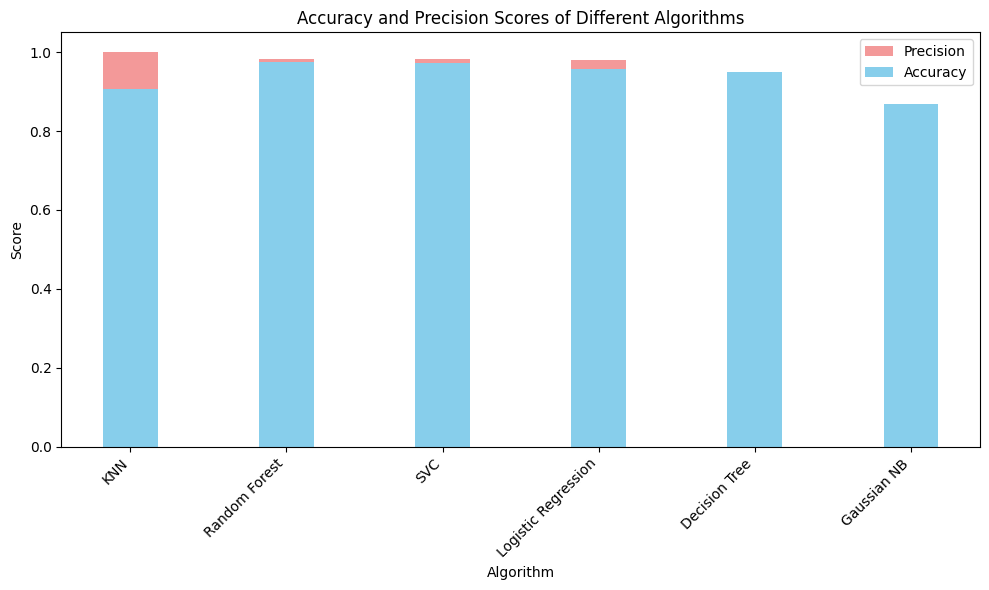

In [185]:
# Graph Accuracy and Precision

plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(scores_df["Algorithm"], scores_df["Precision"], width=bar_width, label="Precision", color='lightcoral', alpha=0.8)
plt.bar(scores_df["Algorithm"], scores_df["Accuracy"], width=bar_width, label="Accuracy", color='skyblue')
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("Accuracy and Precision Scores of Different Algorithms")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()